In [1]:
# automatic nested cross-validation of regression of 'Linear Regression using Step Forward Feature Selection' contrasted with 'Elastic Net' using pipelines as well as ZCA whitening to scale variables..

#https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
#https://machinelearningmastery.com/elastic-net-regression-in-python/
#https://github.com/rasbt/mlxtend/issues/41
#https://github.com/rasbt/mlxtend/issues/69

In [2]:
from abc import ABC, abstractmethod

import itertools

import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from numpy import arange
from numpy import mean
from numpy import std
import numpy as np

import os

import pandas as pd

from random import sample

import random

import re

#from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')

In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [4]:
def read_data():
    df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')
    return(df)

In [5]:
independent = 'Poverty'
outer_k = 10
inner_k = 10
random_st = random.sample(list(np.arange(0,10,1)),1)[0]
print(random_st)

# configure the cross-validation procedure
cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st)

3


In [6]:
# create dataset
y = read_data()[[independent]]
X = read_data()[(read_data().columns).difference([independent]).values]

In [7]:
scores = list()

In [8]:
"""
class model(ABC):
 
    @abstractmethod
    def setEstimators(self):
        estimators_ENetCV = []
        estimators_ENetCV.append(('standardize', ZCA()))

        pass
"""

class regression_model():
    def __init__(self,estimators):
        self.estimators = estimators
        
        # define search
        self.search = Pipeline(self.estimators)
        
        # execute the nested cross-validation
        self.scores = cross_val_score(self.search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
        # report performance
        self.score = [(mean(self.scores), std(self.scores))]
        
    def score(self):
        
        return(self.score)

In [9]:
#elastic

# define the model

estimators_ENetCV = []
estimators_ENetCV.append(('standardize', ZCA()))
estimators_ENetCV.append(('ElasticNetCV', ElasticNetCV(cv=cv_inner, n_alphas=100, random_state=random_st,fit_intercept=1)))

elastic_score = regression_model(estimators_ENetCV)
scores.append(['ElasticNetCV',elastic_score])

In [10]:
#linear

# define the model

linear_enet = ElasticNetCV(cv=cv_inner,alphas=[0], l1_ratio=0,fit_intercept = True)

sfs = SFS(linear_enet, 
          k_features=len(X.columns), 
          forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          cv=cv_inner)

estimators_linear = []
estimators_linear.append(('standardize', ZCA()))
estimators_linear.append(('SFS', sfs))
estimators_linear.append(('linear_enet', linear_enet))

linear_score = regression_model(estimators_linear)
scores.append(['linear_enet',linear_score])

In [11]:
for s in range(0,len(scores)):
    print('Model: ', scores[s][0])
    print('Accuracy: %.3f (%.3f)' % (scores[s][1].score[0][0], scores[s][1].score[0][1]))


Model:  ElasticNetCV
Accuracy: -2.234 (1.896)
Model:  linear_enet
Accuracy: -2.385 (1.936)


In [12]:
#step 1
best_model = [item[0] for item in scores][np.argmin(np.abs([item[1].score[0][0] for item in scores]))]
print(best_model)

ElasticNetCV


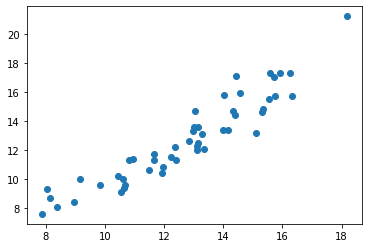

1.1449365449516835


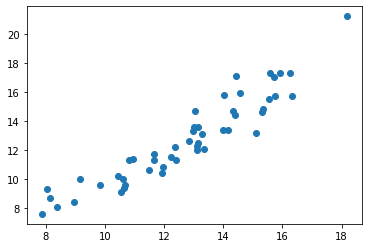

1.1449365449516835


In [14]:


if(best_model=='ElasticNetCV'):
    zca = ZCA()
    zca.fit(X)
    
    #Step 2: inner-procedure is applied to the entire dataset.
    final_model_est = Pipeline(estimators_ENetCV)
    final_model_est.fit(X,y)
    #final_model_est = ElasticNetCV(alphas=[final_model_est.named_steps['ElasticNetCV'].alpha_], l1_ratio=final_model_est.named_steps['ElasticNetCV'].l1_ratio,fit_intercept=True)
    
    #final_model_est.fit(zca.transform(X), y)
    
    #step 3: hyperparameters found during this final search are then used to configure a final model.
    estimators_final = []
    #estimators_final.append(('standardize', ZCA()))
    estimators_final.append(('ElasticNet', ElasticNetCV(cv=cv_inner,alphas=[final_model_est.named_steps['ElasticNetCV'].alpha_], l1_ratio=final_model_est.named_steps['ElasticNetCV'].l1_ratio,fit_intercept=True)))
    final_model = Pipeline(estimators_final)
    
    final_model.fit(zca.transform(X),y)    
    
    #step 4: final model is fit on the entire dataset.
    plt.scatter(final_model.predict(zca.transform(X)),y)
    plt.show()
    print(mean_squared_error(y, final_model.predict(zca.transform(X)), squared=True))
    
    #Step 2: inner-procedure is applied to the entire dataset.
    final_model_est = Pipeline(estimators_ENetCV)
    final_model_est.fit(X,y)
    #final_model_est = ElasticNetCV(alphas=[final_model_est.named_steps['ElasticNetCV'].alpha_], l1_ratio=final_model_est.named_steps['ElasticNetCV'].l1_ratio,fit_intercept=True)
    
    #final_model_est.fit(zca.transform(X), y)
    
    #step 3: hyperparameters found during this final search are then used to configure a final model.
    estimators_final = []
    #estimators_final.append(('standardize', ZCA()))
    estimators_final.append(('ElasticNet', ElasticNetCV(cv=cv_inner,alphas=[final_model_est.named_steps['ElasticNetCV'].alpha_], l1_ratio=final_model_est.named_steps['ElasticNetCV'].l1_ratio,fit_intercept=True)))
    final_model = Pipeline(estimators_final)
    
    final_model.fit(final_model_est.named_steps['standardize'].transform(X),y)    
    
    #step 4: final model is fit on the entire dataset.
    plt.scatter(final_model.predict(final_model_est.named_steps['standardize'].transform(X)),y)
    plt.show()
    print(mean_squared_error(y, final_model.predict(final_model_est.named_steps['standardize'].transform(X)), squared=True))
        
elif(best_model=='linear_enet'):
    final_model_est = Pipeline(estimators_linear)
    
    final_model_est.fit(X,y)
    
    bestSFS=X.columns[pd.Series(pd.DataFrame(final_model_est.named_steps['SFS'].subsets_).iloc[:,np.argmin(np.abs(pd.DataFrame(final_model_est.named_steps['SFS'].subsets_).loc['avg_score']))-1].feature_idx).to_list()]
    
    #Step 2: inner-procedure is applied to the entire dataset.
    #step 3: hyperparameters found during this final search are then used to configure a final model.
    #no need to derive hyper parm's
    final_model = ElasticNetCV(cv=cv_inner,alphas=[0], l1_ratio=0,fit_intercept=True)
    
    zca = ZCA()
    zca.fit(X[bestSFS])
    
    final_model.fit(zca.transform(X[bestSFS]), y)
    
    #final_model.fit(zca.transform(X),y)    
    
    #step 4: final model is fit on the entire dataset.
    plt.scatter(final_model.predict(zca.transform(X[bestSFS])),y)
    plt.show()
    print(mean_squared_error(y, final_model.predict(zca.transform(X[bestSFS])), squared=True))
